In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [4]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [5]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-04-10 07:59:01.494 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-04-10 07:59:01.598 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-04-10 07:59:01.600 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-04-10 07:59:01.602 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-04-10 07:59:01.973 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-04-10 07:59:01.974 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-04-10 07:59:02.316 | DEBUG    | vivarium.

In [6]:
pop0 = sim.get_population()
pop0.head()

,tracked,age,exit_time,location,sex,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_multiplier,polypill,outreach,last_fpg_test_date,sbp_medication_adherence,sbp_medication,ldlc_medication,sbp_multiplier,scheduled_date,visit_type
0,True,47.388882,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,cat2,cat2,NaT,cat3,no_treatment,no_treatment,1.0,NaT,none
1,True,41.564194,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,cat2,cat2,2018-05-22 09:39:56.018321504,cat3,no_treatment,no_treatment,1.0,NaT,none
2,True,53.155826,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,cat2,cat2,2019-06-20 13:12:13.641732984,cat1,no_treatment,no_treatment,1.0,NaT,none
3,True,30.457692,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,cat2,cat2,NaT,cat3,no_treatment,no_treatment,1.0,NaT,none
4,True,19.554806,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,cat2,cat2,NaT,cat3,no_treatment,no_treatment,1.0,NaT,none


In [7]:
pop0.columns

Index(['tracked', 'age', 'exit_time', 'location', 'sex', 'alive',
       'entrance_time', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'susceptible_to_ischemic_st

In [8]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'sbp_medication_adherence.propensity',
 'sbp_medication_adherence.exposure',
 'risk_factor.sbp_medication_adherence.exposure_parameters',
 'ldlc_medication_adherence.propensity',
 'ldlc_medication_adherence.exposure',
 'risk_factor.ldlc_medication_adherence.exposure_parameters',
 'outreach.propensity',
 'outreach.exposure',
 'risk_factor.outreach.exposure_parameters',
 'risk_factor.outreach.exposure_parameters.paf',
 'polypill.propensity',
 'polypill.exposure',
 'risk_factor.polypill.exposure_parameters',
 'risk_factor.polypill.exposure_parameters.paf',
 'lifestyle.propensity',
 'lifestyle.exposure',
 'risk_factor.lifestyle.exposure_parameters',
 'risk_factor.lifestyle.exposure_parameters.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardia

In [9]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                  ], axis=1)
data1.head()

,tracked,age,exit_time,location,sex,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,sbp_multiplier,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi
0,True,47.388882,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,NaT,none,2.644998,127.134134,24.802611,6.138124,0.000024,0.000063,0.000012
1,True,41.564194,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,NaT,none,3.376564,131.808766,27.165902,4.975500,0.000020,0.000056,0.000022
2,True,53.155826,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,NaT,none,2.074324,106.466069,33.998750,7.768995,0.000052,0.000096,0.000031
3,True,30.457692,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,NaT,none,3.756715,109.868926,27.233734,5.494943,0.000012,0.000055,0.000005
4,True,19.554806,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,1.0,NaT,none,0.000000,50.000000,5.000000,1.000000,0.000001,0.000024,0.000008


In [10]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [11]:
len(data1.loc[(data1.ldlc_medication == 'no_treatment') & (data1.age > 70)])/len(data1.loc[data1.age > 70])

0.566694987255735

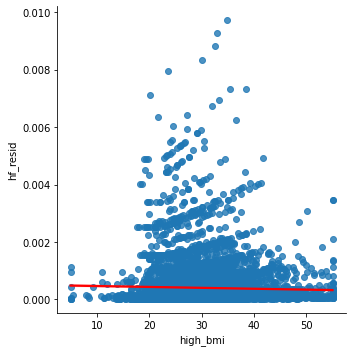

In [12]:
import seaborn as sns
sns.lmplot(x='high_bmi',y='hf_resid',data=data1, line_kws={'color': 'red'})

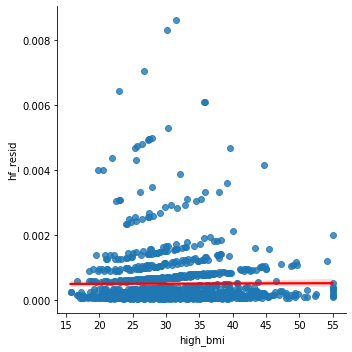

In [10]:
data_sbp_cat1 = data1.loc[(data1.high_sbp > 130) & (data1.high_sbp < 140)]
sns.lmplot(x='high_bmi',y='hf_resid',data=data_sbp_cat1, line_kws={'color': 'red'})

## Testing Exposure Compared to Artifact in 2021

In [13]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

ls: cannot access '/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/': No such file or directory


In [15]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [18]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.35,0.975], axis=1).filter(['mean','35%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### SBP

In [33]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

/tmp/ipykernel_923009/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,110.635893,107.945700,113.550750,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,112.876275,110.098198,115.523727,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,116.139886,113.594023,118.770064,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,118.491616,115.903577,121.039457,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,121.645391,118.875235,124.529834,Alabama,exposure,45_to_49


In [34]:
sbp_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_sbp.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
sbp_exp = sbp_exp.loc[sbp_exp.age_start < 105]
sbp_exp.head()

,age_start,sex,mean,2.5%,97.5%
0,25.0,Female,109.695929,94.339877,132.515226
1,25.0,Male,115.022512,99.413975,137.335227
2,30.0,Female,114.047114,96.991292,140.487381
3,30.0,Male,120.816407,102.353818,148.692978
4,35.0,Female,115.922507,90.364984,144.430252


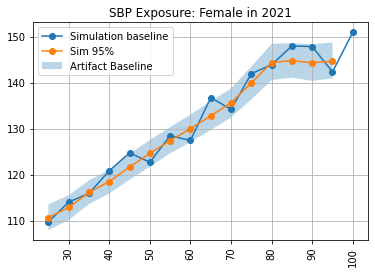

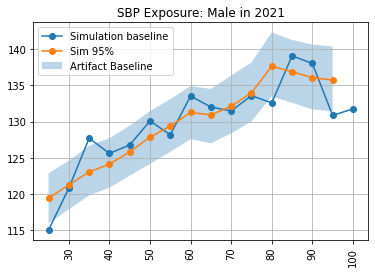

In [35]:
for sex in sbp_exp.sex.unique():
    plt.figure() 
    subdata = sbp_exp.loc[(sbp_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [18]:
data1.loc[data1.age_start > 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
4700,True,106.524522,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.328884,187.779511,23.861687,6.119356,0.005735,0.004658,0.002334,105.0
6575,True,108.032306,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,2021-02-14 12:33:06.970780800,none,2.808106,137.643584,31.466309,8.347287,0.013222,0.008608,0.007617,105.0


Looks like the ends of the graph is just due to there being only one person in those groups! I removed them for clarity

### LDL-C

In [100]:
ldl_art_all = art.load('risk_factor.high_ldl_cholesterol.exposure')
ldl_art_all = ldl_art_all.loc[ldl_art_all.index.get_level_values('age_start') > 70]
ldl_small = ldl_art_all.apply(pd.DataFrame.describe, percentiles=[0.65], axis=1).filter(['65%']).reset_index()
ldl_small.mean()

/tmp/ipykernel_923009/2109636798.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ldl_small.mean()


age_start       85.000000
age_end         95.000000
year_start    2019.000000
year_end      2020.000000
65%              2.910916
dtype: float64

In [89]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

/tmp/ipykernel_923009/795945589.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.639862,2.600945,2.472574,2.821188,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.724353,2.691550,2.553736,2.905134,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.802925,2.772667,2.639513,2.972487,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.880791,2.850118,2.721814,3.039119,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,2.998297,2.963904,2.837974,3.175367,Alabama,exposure,45_to_49


In [82]:
ldl_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_ldl.describe(percentiles=[.025, 0.35,.975])
                .filter(['mean','35%','2.5%','97.5%'])
                .reset_index())
ldl_exp

,age_start,sex,mean,35%,2.5%,97.5%
0,25.0,Female,2.620946,2.244025,1.051474,4.492790
1,25.0,Male,2.810904,2.365098,1.310526,4.687545
2,30.0,Female,2.702871,2.361349,1.158204,4.345764
3,30.0,Male,2.852065,2.519793,1.394397,4.602793
4,35.0,Female,2.769553,2.422764,1.289963,4.448486
5,35.0,Male,2.974062,2.657912,1.245755,4.996418
6,40.0,Female,2.750465,2.343496,1.177530,4.762312
7,40.0,Male,3.085771,2.727518,1.375213,4.957234
8,45.0,Female,2.950846,2.585639,1.405571,5.012120
9,45.0,Male,2.998687,2.604313,1.341587,4.884875


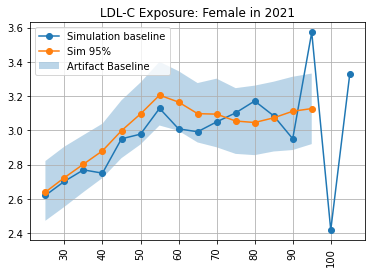

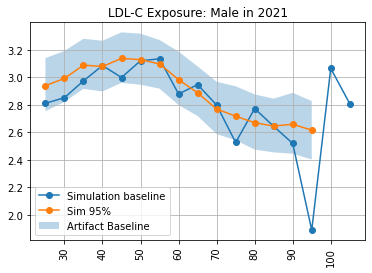

In [38]:
for sex in ldl_exp.sex.unique():
    plt.figure() 
    subdata = ldl_exp.loc[(ldl_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL-C Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [22]:
data1.loc[data1.age_start == 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
2108,True,101.601737,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.806020,194.654956,28.820533,5.647478,0.006498,0.005278,0.002028,100.0
2285,True,104.867639,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.409409,131.617414,25.428487,9.634173,0.005316,0.004318,0.001913,100.0
4871,True,104.731512,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.022770,134.074676,30.117374,8.114999,0.012780,0.008320,0.005216,100.0
7436,True,100.593125,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,4.106867,129.441540,30.292312,6.212580,0.010671,0.006947,0.004901,100.0
7744,True,100.136283,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.881371,138.752634,20.549861,4.270128,0.004938,0.004010,0.000552,100.0
8042,True,104.439608,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.577250,138.738971,19.741234,5.641705,0.004938,0.004010,0.000462,100.0


Again, the issues at the end of the graph look like they are due to small samples

## BMI too

In [19]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

/tmp/ipykernel_32641/240823744.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,30.899912,30.834806,30.572156,31.233780,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,31.636913,31.572002,31.293987,31.989474,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,31.883495,31.819942,31.555235,32.210906,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,32.130649,32.065292,31.801051,32.462829,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,32.169931,32.101729,31.855765,32.505542,Alabama,exposure,45_to_49


In [21]:
bmi_exp = (data1
                .groupby(['age_start', 'sex'])
                .high_bmi.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
bmi_exp = bmi_exp.loc[bmi_exp.age_start < 105]
bmi_exp.head()

,age_start,sex,mean,2.5%,97.5%
0,25.0,Female,30.429599,15.748353,50.808651
1,25.0,Male,29.119499,17.145312,47.206215
2,30.0,Female,31.624292,17.902438,53.565990
3,30.0,Male,30.305817,19.311306,46.005232
4,35.0,Female,31.437472,16.492798,52.796450


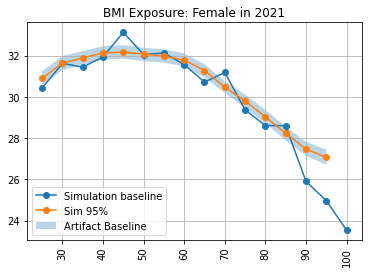

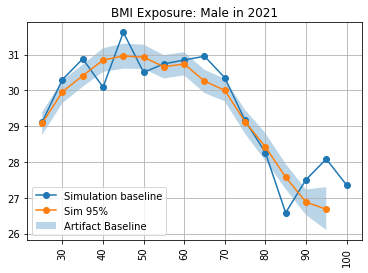

In [22]:
for sex in bmi_exp.sex.unique():
    plt.figure() 
    subdata = bmi_exp.loc[(bmi_exp.sex==sex)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'BMI Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Testing for Medication Increases in SBP

In [73]:
sim_data = pd.DataFrame()
for step in list(range(0,100)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity')],                       
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])

2023-04-10 09:16:53.438 | DEBUG    | vivarium.framework.engine:step:172 - 2028-09-01 00:00:00
2023-04-10 09:17:20.232 | DEBUG    | vivarium.framework.engine:step:172 - 2028-09-29 00:00:00
2023-04-10 09:17:46.930 | DEBUG    | vivarium.framework.engine:step:172 - 2028-10-27 00:00:00
2023-04-10 09:18:14.180 | DEBUG    | vivarium.framework.engine:step:172 - 2028-11-24 00:00:00
2023-04-10 09:18:41.350 | DEBUG    | vivarium.framework.engine:step:172 - 2028-12-22 00:00:00
2023-04-10 09:19:08.256 | DEBUG    | vivarium.framework.engine:step:172 - 2029-01-19 00:00:00
2023-04-10 09:19:35.577 | DEBUG    | vivarium.framework.engine:step:172 - 2029-02-16 00:00:00
2023-04-10 09:20:02.637 | DEBUG    | vivarium.framework.engine:step:172 - 2029-03-16 00:00:00
2023-04-10 09:20:29.445 | DEBUG    | vivarium.framework.engine:step:172 - 2029-04-13 00:00:00
2023-04-10 09:20:56.302 | DEBUG    | vivarium.framework.engine:step:172 - 2029-05-11 00:00:00
2023-04-10 09:21:23.703 | DEBUG    | vivarium.framework.engi

In [74]:
data_all = sim_data.loc[(sim_data.age > 25) & (sim_data.alive == 'alive')]
data_all['age_start'] = ((data_all.age/5).astype(int) * 5).astype(float)
data_all['sbp_med_short'] = np.where(data_all.sbp_medication == 'no_treatment', 'none',np.where(data_all.sbp_medication == 'one_drug_half_dose_efficacy', 'one_half',np.where(data_all.sbp_medication == 'one_drug_std_dose_efficacy','one_std', np.where(data_all.sbp_medication == 'two_drug_half_dose_efficacy', 'two_half', np.where(data_all.sbp_medication == 'two_drug_std_dose_efficacy', 'two_std',np.where(data_all.sbp_medication == 'three_drug_half_dose_efficacy','three_half','three_std'))))))
data_all.head()

,tracked,age,exit_time,location,sex,alive,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,visit_type,high_ldl,high_sbp,high_bmi,bmi_propensity,high_fpg,sbp_propensity,step,age_start,sbp_med_short
0,True,55.131524,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,none,2.775422,132.107980,25.176512,0.208828,8.069470,0.650952,0,55.0,none
1,True,49.306836,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,none,3.282964,127.803453,27.693307,0.358604,5.161703,0.625507,0,45.0,one_half
2,True,60.898468,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,none,1.976641,108.858431,33.458021,0.531571,8.519321,0.165289,0,60.0,none
3,True,38.200334,NaT,Alabama,Male,alive,2020-12-04,not_dead,0.0,0.0,...,none,3.959135,115.731305,27.700401,0.388049,6.155928,0.162353,0,35.0,none
4,True,27.297448,NaT,Alabama,Female,alive,2020-12-04,not_dead,0.0,0.0,...,none,3.078126,107.724603,33.078507,0.672873,4.582394,0.479221,0,25.0,none


In [111]:
HF_regression = data_all[['age_start','sex','high_sbp','high_bmi','high_ldl','high_fpg','heart_failure_from_ischemic_heart_disease_event_count','heart_failure_residual_event_count']]
HF_regression['bmi_exposure'] = np.where(HF_regression.high_bmi < 22.5, 0, (HF_regression.high_bmi - 22.5))
HF_regression['sbp_exposure'] = np.where(HF_regression.high_sbp < 120, 0, (HF_regression.high_sbp - 120)/10)
HF_regression['hf_both'] = HF_regression.heart_failure_from_ischemic_heart_disease_event_count + HF_regression.heart_failure_residual_event_count
HF_regression['hf_both_binary'] = np.where(HF_regression.hf_both > 0, 1, 0)
HF_regression['hf_ihd_binary'] = np.where(HF_regression.heart_failure_from_ischemic_heart_disease_event_count > 0, 1, 0)
HF_regression.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,high_fpg,heart_failure_from_ischemic_heart_disease_event_count,heart_failure_residual_event_count,bmi_exposure,sbp_exposure,hf_both,hf_both_binary,hf_ihd_binary
0,45.0,Female,127.134134,24.802611,2.644998,6.138124,0,0,2.302611,0.713413,0,0,0
1,40.0,Male,131.808766,27.165902,3.376564,4.975500,0,0,4.665902,1.180877,0,0,0
2,50.0,Female,106.466069,33.998750,2.074324,7.768995,0,0,11.498750,0.000000,0,0,0
3,30.0,Male,109.868926,27.233734,3.756715,5.494943,0,0,4.733734,0.000000,0,0,0
6,30.0,Male,132.593806,24.365348,1.946794,5.426104,0,0,1.865348,1.259381,0,0,0


In [112]:
HF_regression.loc[HF_regression['hf_ihd_binary'] > 0]
HF_regression_small = HF_regression.loc[HF_regression.high_bmi < 37]
HF_regression_small.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,high_fpg,heart_failure_from_ischemic_heart_disease_event_count,heart_failure_residual_event_count,bmi_exposure,sbp_exposure,hf_both,hf_both_binary,hf_ihd_binary
0,45.0,Female,127.134134,24.802611,2.644998,6.138124,0,0,2.302611,0.713413,0,0,0
1,40.0,Male,131.808766,27.165902,3.376564,4.975500,0,0,4.665902,1.180877,0,0,0
2,50.0,Female,106.466069,33.998750,2.074324,7.768995,0,0,11.498750,0.000000,0,0,0
3,30.0,Male,109.868926,27.233734,3.756715,5.494943,0,0,4.733734,0.000000,0,0,0
6,30.0,Male,132.593806,24.365348,1.946794,5.426104,0,0,1.865348,1.259381,0,0,0


In [113]:
model = smf.logit("hf_ihd_binary ~ bmi_exposure", data = HF_regression_small).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='bmi_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

Optimization terminated successfully.
         Current function value: 0.022543
         Iterations 10


,coeff,rr
bmi_exposure,-0.046806,0.954273


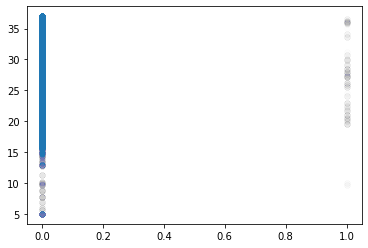

In [120]:
plt.scatter(HF_regression_small.hf_ihd_binary, HF_regression_small.high_bmi, alpha=0.004)

In [77]:
model = smf.logit("hf_ihd_binary ~ sbp_exposure", data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

Optimization terminated successfully.
         Current function value: 0.057750
         Iterations 9


,coeff,rr
sbp_exposure,0.292618,1.339931


In [55]:
data_all.sbp_medication.unique()

array(['no_treatment', 'one_drug_half_dose_efficacy',
       'two_drug_half_dose_efficacy', 'two_drug_std_dose_efficacy',
       'one_drug_std_dose_efficacy', 'three_drug_half_dose_efficacy',
       'three_drug_std_dose_efficacy'], dtype=object)

(array([3., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 2., 1., 1., 0., 1.,
        1., 1., 1.]),
 array([0.00817929, 0.05177132, 0.09536336, 0.13895539, 0.18254742,
        0.22613945, 0.26973148, 0.31332351, 0.35691555, 0.40050758,
        0.44409961, 0.48769164, 0.53128367, 0.5748757 , 0.61846774,
        0.66205977, 0.7056518 , 0.74924383, 0.79283586, 0.83642789,
        0.88001993]),
 <BarContainer object of 20 artists>)

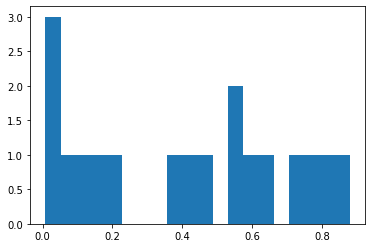

In [75]:
plt.hist(data_all.loc[(data_all.age_start == 95) & (data_all.step == 1) & (data_all.alive == 'alive')].bmi_propensity, bins=20)

In [76]:
data_all.loc[(data_all.age_start == 50) & (data_all.step == 1) & (data_all.alive == 'alive')].bmi_propensity.median()

0.49845948250807587

(array([2., 0., 0., 3., 1., 1., 3., 1., 1., 0., 3., 0., 3., 1., 1., 1., 1.,
        0., 0., 1.]),
 array([0.00228378, 0.04707281, 0.09186183, 0.13665086, 0.18143989,
        0.22622892, 0.27101794, 0.31580697, 0.360596  , 0.40538503,
        0.45017405, 0.49496308, 0.53975211, 0.58454114, 0.62933016,
        0.67411919, 0.71890822, 0.76369725, 0.80848627, 0.8532753 ,
        0.89806433]),
 <BarContainer object of 20 artists>)

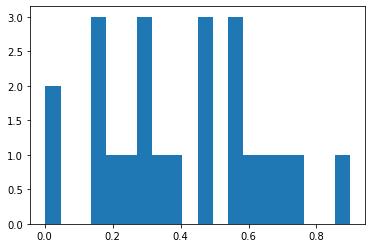

In [77]:
plt.hist(data_all.loc[(data_all.age_start == 95) & (data_all.step == 99) & (data_all.alive == 'alive')].bmi_propensity, bins=20)

In [78]:
data_all.loc[(data_all.age_start == 50) & (data_all.step == 99) & (data_all.alive == 'alive')].bmi_propensity.median()

0.5102848120419113

In [106]:
line = data_all.loc[(data_all.age_start > 60) & (data_all.alive == 'alive')].groupby('step').bmi_propensity.median().reset_index()
line

,step,bmi_propensity
0,0,0.515382
1,1,0.515135
2,2,0.515851
3,3,0.514887
4,4,0.512942
...,...,...
95,95,0.488535
96,96,0.485545
97,97,0.485539
98,98,0.485539


Text(0, 0.5, 'BMI Propensity Median')

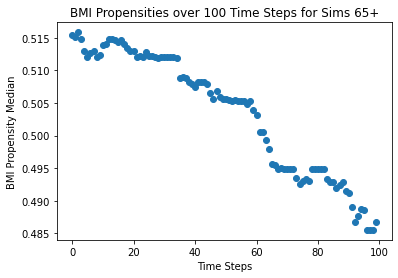

In [108]:
plt.scatter(line.step, line.bmi_propensity)
plt.title('BMI Propensities over 100 Time Steps for Sims 65+')
plt.xlabel('Time Steps')
plt.ylabel('BMI Propensity Median')

In [ ]:
##Make a historgram of the propensities of the living simulations 

(array([34., 44., 36., 28., 38., 42., 23., 38., 40., 37., 40., 35., 47.,
        40., 30., 32., 35., 55., 33., 34.]),
 array([0.00130343, 0.05113439, 0.10096534, 0.1507963 , 0.20062725,
        0.25045821, 0.30028917, 0.35012012, 0.39995108, 0.44978203,
        0.49961299, 0.54944395, 0.5992749 , 0.64910586, 0.69893682,
        0.74876777, 0.79859873, 0.84842968, 0.89826064, 0.9480916 ,
        0.99792255]),
 <BarContainer object of 20 artists>)

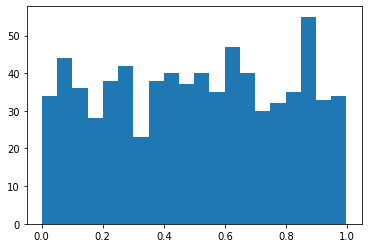

In [73]:
plt.hist(data_all.loc[(data_all.age_start == 25) & (data_all.step == 1) & (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([40., 36., 39., 29., 33., 27., 38., 29., 39., 35., 27., 36., 29.,
        35., 36., 47., 35., 45., 26., 32.]),
 array([2.98632678e-04, 5.01426944e-02, 9.99867561e-02, 1.49830818e-01,
        1.99674879e-01, 2.49518941e-01, 2.99363003e-01, 3.49207065e-01,
        3.99051126e-01, 4.48895188e-01, 4.98739250e-01, 5.48583311e-01,
        5.98427373e-01, 6.48271435e-01, 6.98115496e-01, 7.47959558e-01,
        7.97803620e-01, 8.47647681e-01, 8.97491743e-01, 9.47335805e-01,
        9.97179866e-01]),
 <BarContainer object of 20 artists>)

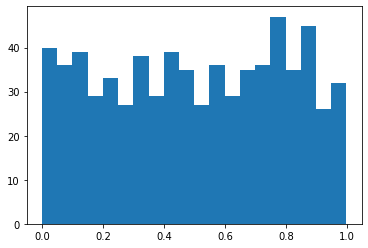

In [74]:
plt.hist(data_all.loc[(data_all.age_start == 25) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([24., 13., 18., 17., 24., 25., 18., 17., 24., 20., 18., 26., 22.,
        16., 19., 19., 17., 31., 14., 17.]),
 array([0.00237308, 0.05206957, 0.10176606, 0.15146255, 0.20115905,
        0.25085554, 0.30055203, 0.35024852, 0.39994501, 0.4496415 ,
        0.49933799, 0.54903448, 0.59873098, 0.64842747, 0.69812396,
        0.74782045, 0.79751694, 0.84721343, 0.89690992, 0.94660641,
        0.99630291]),
 <BarContainer object of 20 artists>)

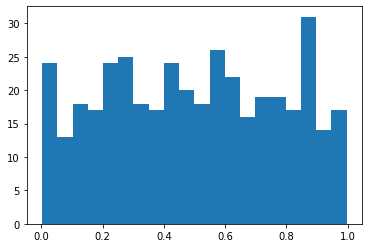

In [75]:
plt.hist(data_all.loc[(data_all.age_start > 75) & (data_all.step == 1) & (data_all.alive == 'alive')].sbp_propensity, bins=20)

(array([34., 26., 19., 31., 35., 25., 22., 26., 29., 26., 32., 31., 42.,
        28., 25., 27., 24., 34., 24., 24.]),
 array([0.00237308, 0.05225007, 0.10212706, 0.15200405, 0.20188105,
        0.25175804, 0.30163503, 0.35151202, 0.40138901, 0.451266  ,
        0.50114299, 0.55101998, 0.60089697, 0.65077396, 0.70065095,
        0.75052795, 0.80040494, 0.85028193, 0.90015892, 0.95003591,
        0.9999129 ]),
 <BarContainer object of 20 artists>)

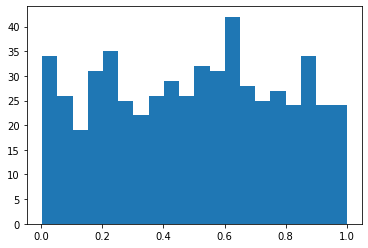

In [76]:
plt.hist(data_all.loc[(data_all.age_start > 75) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity, bins=20)

In [78]:
data_all.loc[(data_all.age_start > 75) & (data_all.step == 99)& (data_all.alive == 'alive')].sbp_propensity.mean()

0.49989823405818967

In [85]:
data_all.alive.value_counts()

alive    766284
Name: alive, dtype: int64

In [99]:
line = data_all.loc[(data_all.age_start > 60) & (data_all.alive == 'alive')].groupby('step').sbp_propensity.mean().reset_index()
line

,step,sbp_propensity
0,0,0.497402
1,1,0.496986
2,2,0.497192
3,3,0.495932
4,4,0.495790
...,...,...
95,95,0.497379
96,96,0.497512
97,97,0.497545
98,98,0.497495


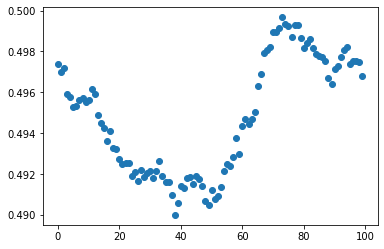

In [101]:
plt.scatter(line.step, line.sbp_propensity)

(array([4811.,    0., 1770.,    0.,    0.,  733.,    0.,   68.,    0.,
          71.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

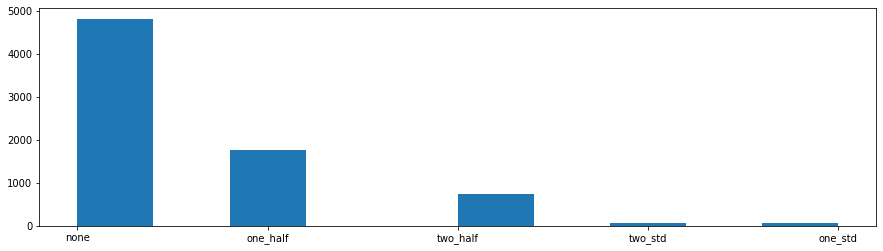

In [41]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 0].sbp_med_short)

(array([4184., 2077.,    0.,   72.,    0.,  791.,  166.,    0.,  171.,
          25.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

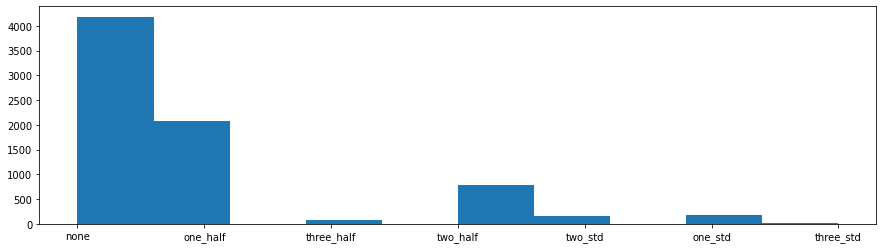

In [42]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 5].sbp_med_short)

(array([3625., 2341.,    0.,  347.,    0.,  732.,  183.,    0.,  227.,
         138.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

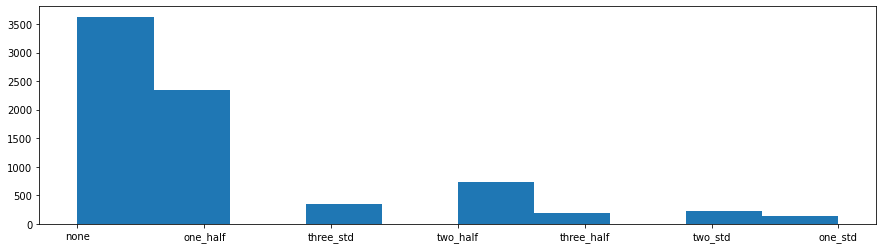

In [44]:
plt.figure(figsize=(15,4))
plt.hist(data_all[data_all.step == 24].sbp_med_short)

(array([168.,   0.,  31.,   0.,  90.,   0.,  91.,   0.,  15.,   4.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

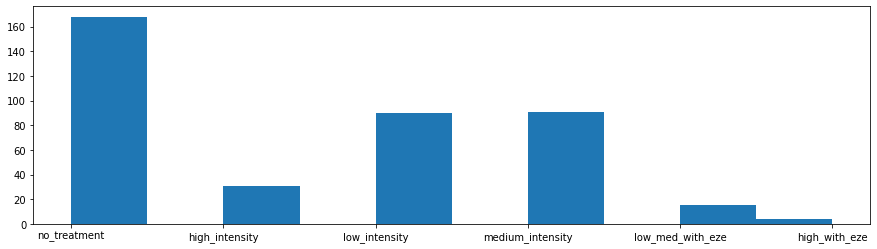

In [74]:
plt.figure(figsize=(15,4))
plt.hist(data_all[(data_all.step == 0) & (data_all.age_start > 75)].ldlc_medication)

(array([831.,   0., 350.,   0., 180.,   0., 202.,   0., 303.,  96.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

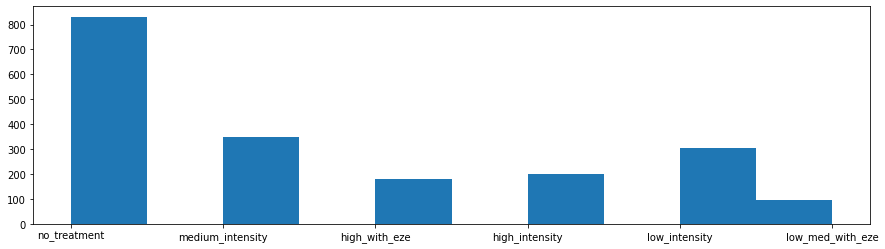

In [48]:
plt.figure(figsize=(15,4))
plt.hist(data_all[(data_all.step == 24) & (data_all.age_start > 60)].ldlc_medication)

In [54]:
ldl_meds = (data_all
                .groupby(['age_start', 'sex', 'step', 'ldlc_medication'])
                .count())
ldl_meds.head()

tracked  exit_time  location  \
age_start sex    step ldlc_medication                                  
25.0      Female 0    high_intensity          5          0         5   
                      low_intensity           6          0         6   
                      medium_intensity       13          0        13   
                      no_treatment          352          0       352   
                 1    high_intensity          5          0         5   

                                        entrance_time  age  alive  \
age_start sex    step ldlc_medication                               
25.0      Female 0    high_intensity                5    5      5   
                      low_intensity                 6    6      6   
                      medium_intensity             13   13     13   
                      no_treatment                352  352    352   
                 1    high_intensity                5    5      5   

                                        years_of_life_lost  cause_of_death  \
age_start sex    step ldlc_medication                                        
25.0      Female 0    high_intensity                     5               5   
                      low_intensity                      6               6   
                      medium_intensity                  13              13   
                      no_treatment                     352             352   
                 1    high_intensity                     5               5   

                                        years_lived_with_disability  \
age_start sex    step ldlc_medication                                 
25.0      Female 0    high_intensity                              5   
                      low_intensity                               6   
                      medium_intensity                           13   
                      no_treatment                              352   
                 1    high_intensity                              5   

                                        previous_ischemic_stroke  ...  \
age_start sex    step ldlc_medication                             ...   
25.0      Female 0    high_intensity                           5  ...   
                      low_intensity                            6  ...   
                      medium_intensity                        13  ...   
                      no_treatment                           352  ...   
                 1    high_intensity                           5  ...   

                                        sbp_multiplier  last_fpg_test_date  \
age_start sex    step ldlc_medication                                        
25.0      Female 0    high_intensity                 5                   0   
                      low_intensity                  6                   0   
                      medium_intensity              13                   0   
                      no_treatment                 352                   0   
                 1    high_intensity                 5                   0   

                                        scheduled_date  visit_type  high_ldl  \
age_start sex    step ldlc_medication                                          
25.0      Female 0    high_intensity                 0           5         5   
                      low_intensity                  0           6         6   
                      medium_intensity               3          13        13   
                      no_treatment                   5         352       352   
                 1    high_intensity                 0           5         5   

                                        high_sbp  high_bmi  high_fpg  \
age_start sex    step ldlc_medication                                  
25.0      Female 0    high_intensity           5         5         5   
                      low_intensity            6         6         6   
                      medium_intensity        13        13        13   
                      no_t

/tmp/ipykernel_923009/1426759024.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


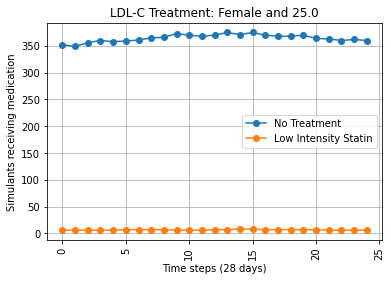

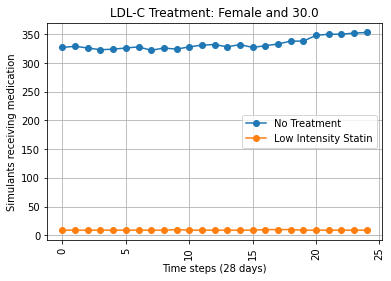

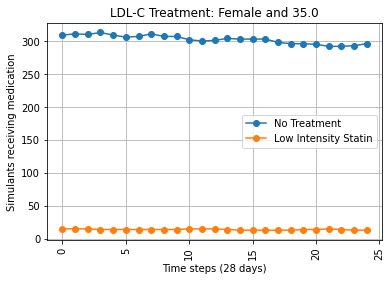

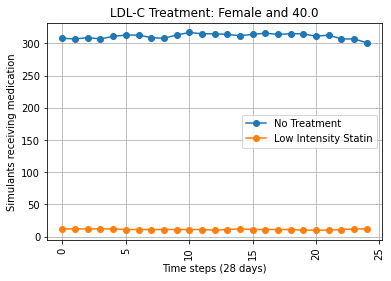

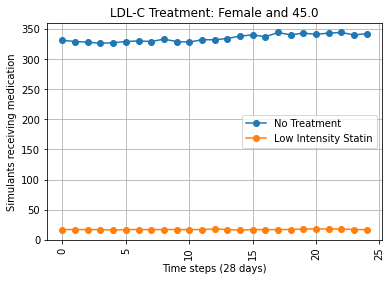

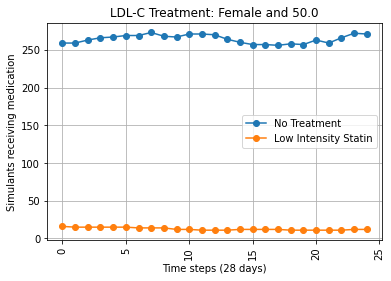

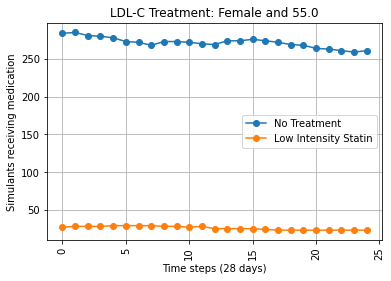

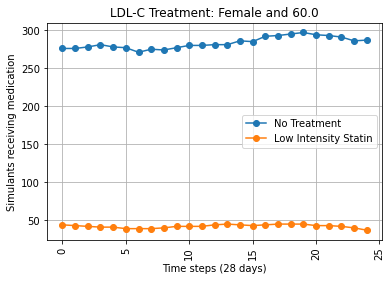

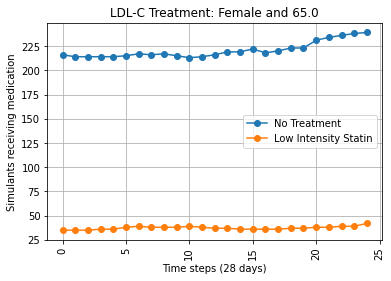

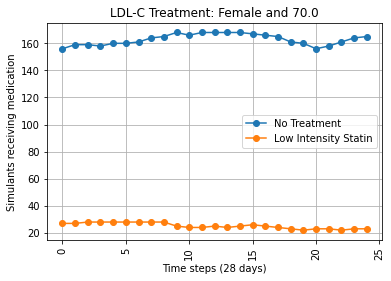

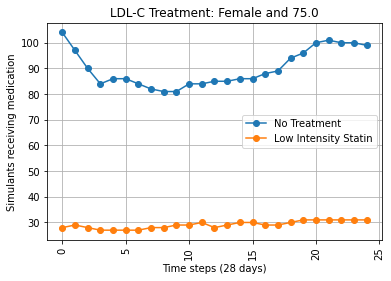

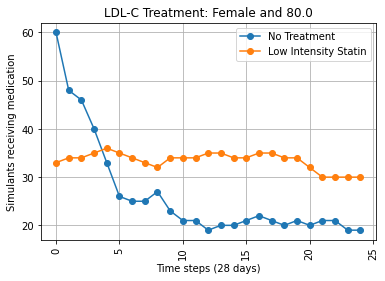

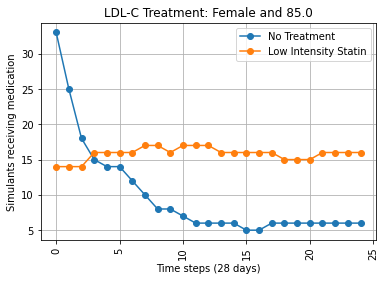

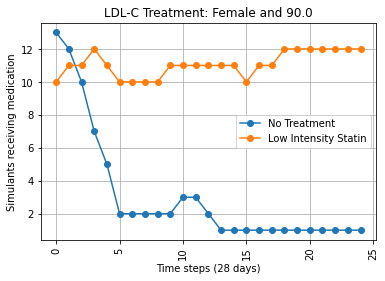

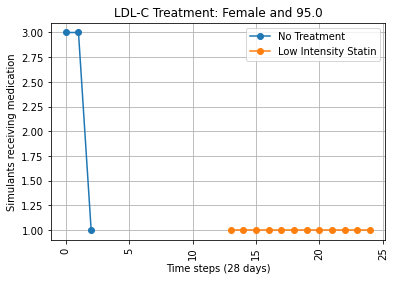

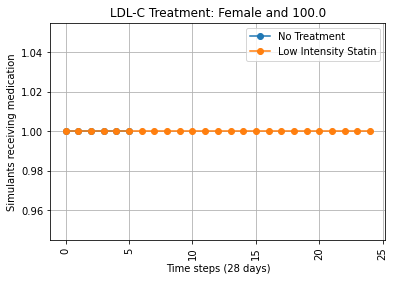

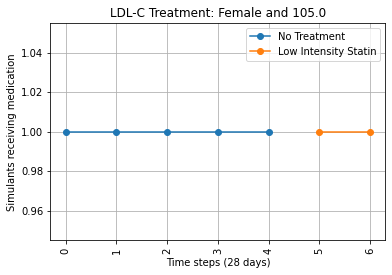

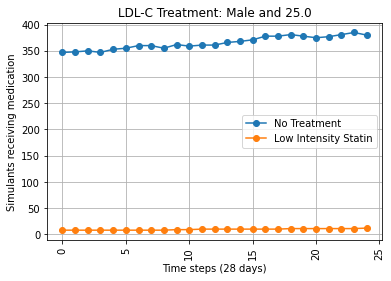

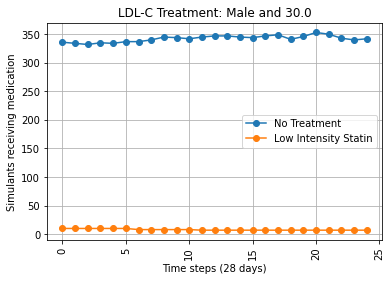

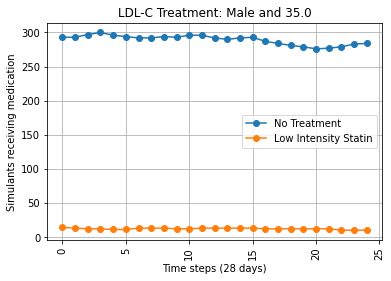

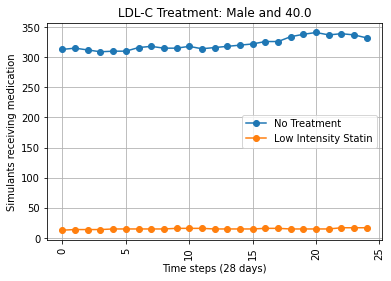

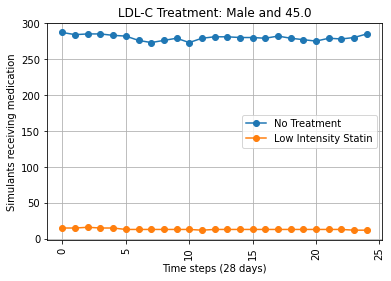

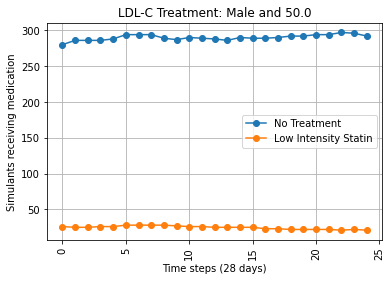

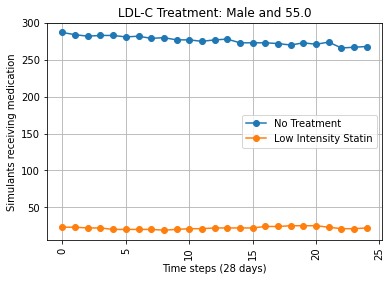

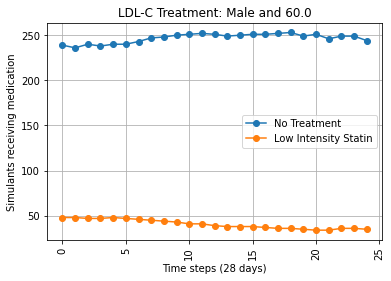

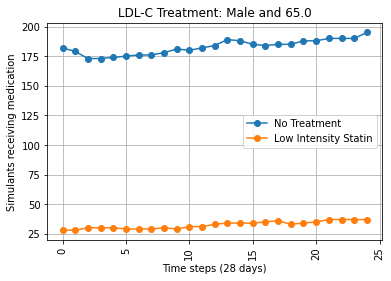

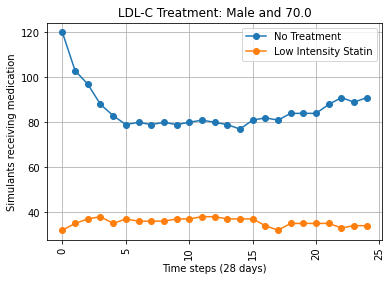

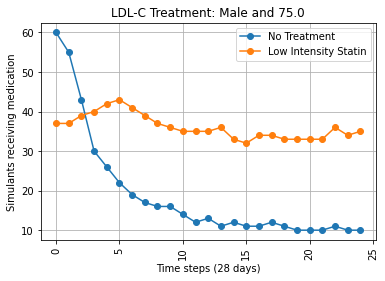

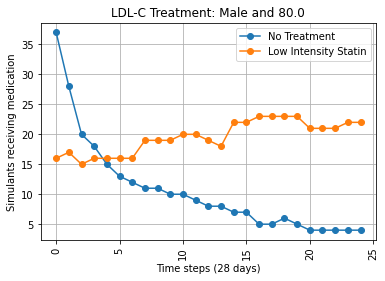

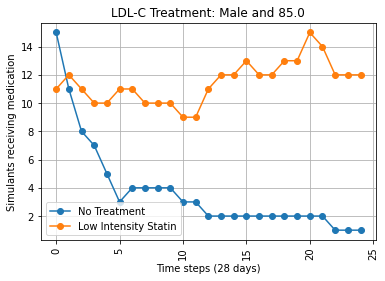

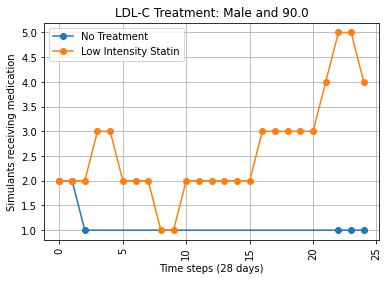

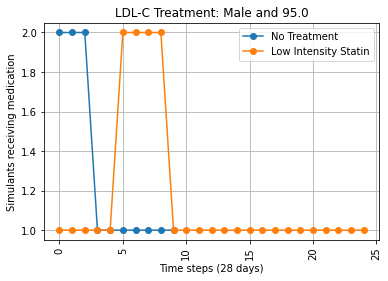

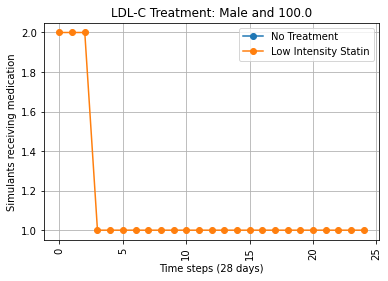

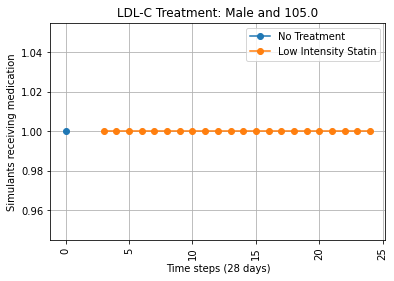

In [73]:
for sex in ldl_meds.index.get_level_values('sex').unique():
    for age in ldl_meds.index.get_level_values('age_start').unique():
        plt.figure() 
        subdata = ldl_meds.loc[(ldl_meds.index.get_level_values('sex')==sex) & (ldl_meds.index.get_level_values('age_start') == age)& (ldl_meds.index.get_level_values('ldlc_medication') == 'no_treatment')]
        plt.plot(subdata.index.get_level_values('step'), subdata['tracked'], marker='o')
        subdata2 = ldl_meds.loc[(ldl_meds.index.get_level_values('sex')==sex) & (ldl_meds.index.get_level_values('age_start') == age)& (ldl_meds.index.get_level_values('ldlc_medication') == 'low_intensity')]
        plt.plot(subdata2.index.get_level_values('step'), subdata2['tracked'], marker='o')
        plt.title(f'LDL-C Treatment: {sex} and {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,150)
        plt.legend(['No Treatment', 'Low Intensity Statin'])
        plt.xlabel('Time steps (28 days)')
        plt.ylabel('Simulants receiving medication')
        plt.grid()


In [48]:
sbp_exp_step = (data_all
                .groupby(['age_start', 'sex', 'step'])
                .high_sbp.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
sbp_exp_step.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,109.763541,94.366671,132.482994
1,25.0,Female,1,109.715144,94.355954,132.272194
2,25.0,Female,2,109.698650,94.388106,132.024395
3,25.0,Female,3,109.772129,94.414899,131.783997
4,25.0,Female,4,109.717781,94.404182,131.884820


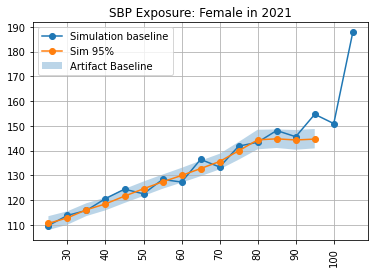

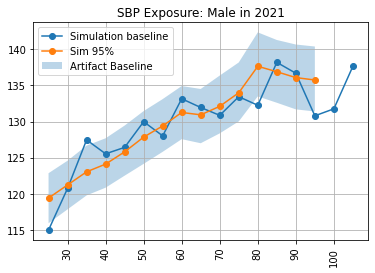

In [49]:
for sex in sbp_exp_step.sex.unique():
    plt.figure() 
    subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.step == 0)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

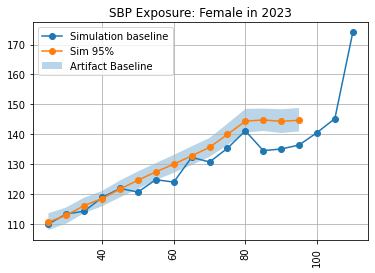

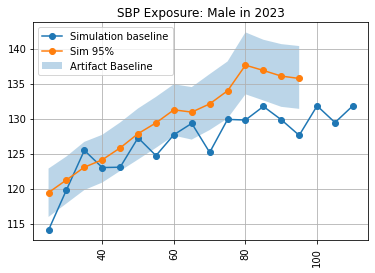

In [50]:
for sex in sbp_exp_step.sex.unique():
    plt.figure() 
    subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.step == 59)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

/tmp/ipykernel_3409029/1562487388.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


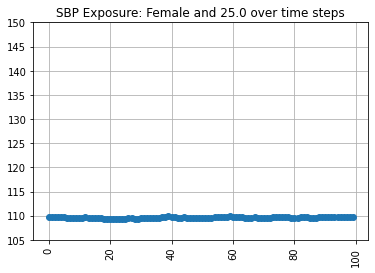

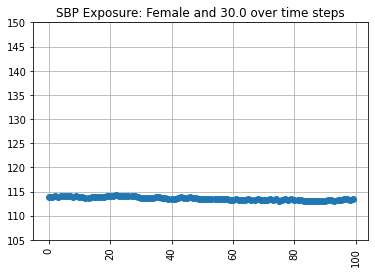

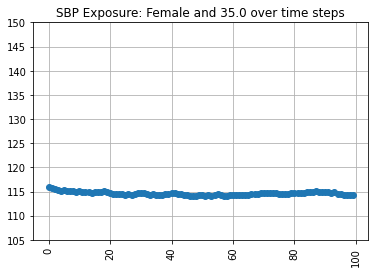

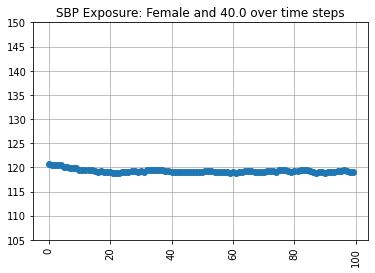

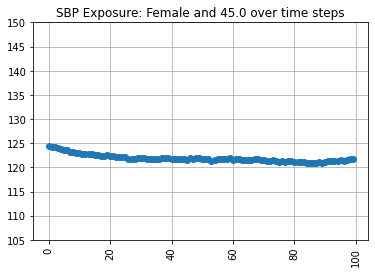

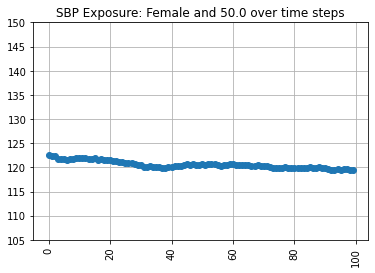

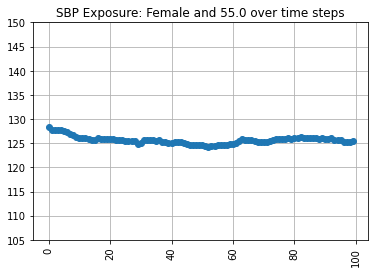

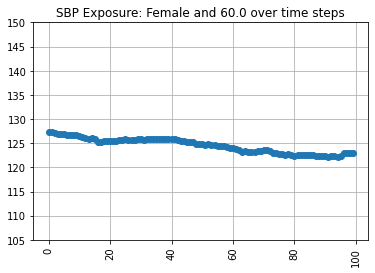

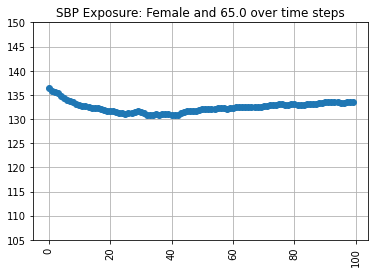

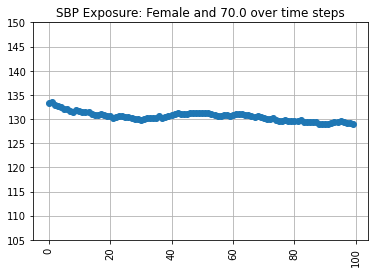

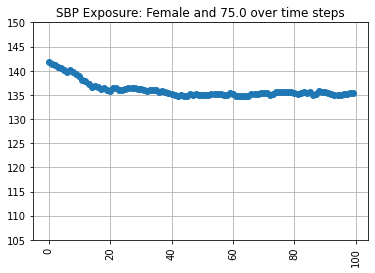

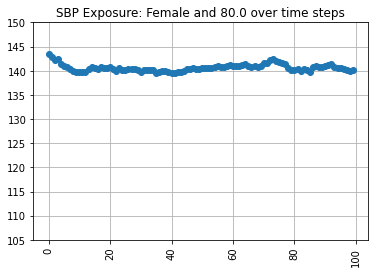

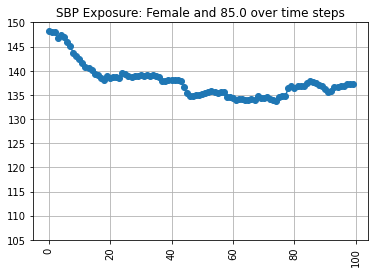

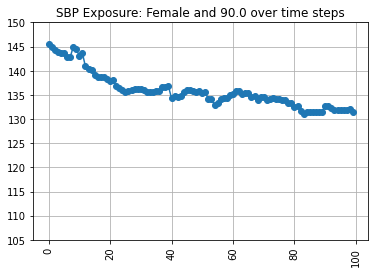

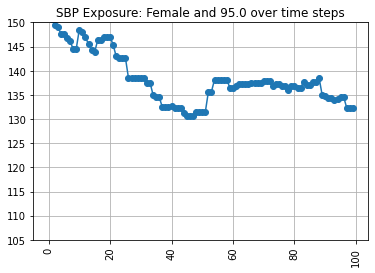

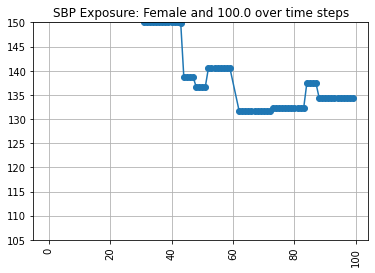

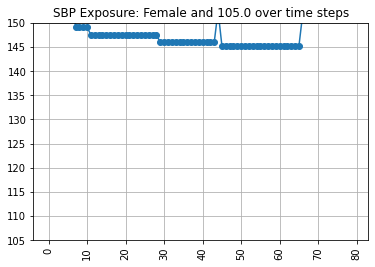

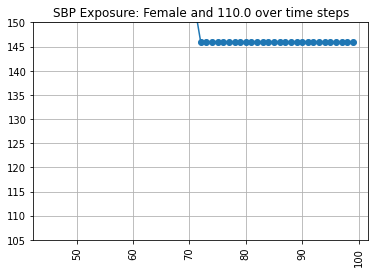

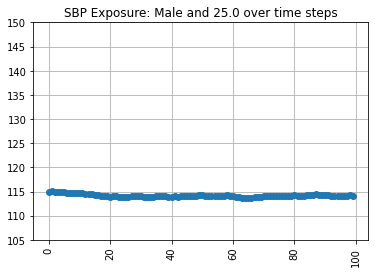

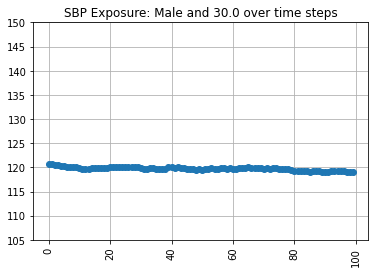

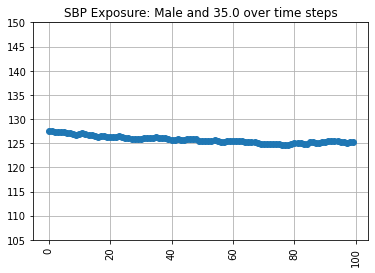

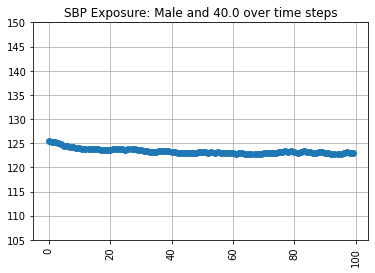

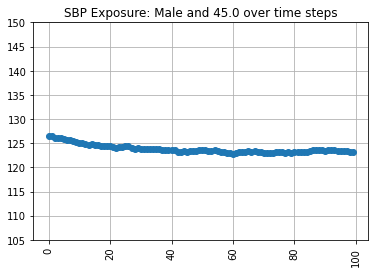

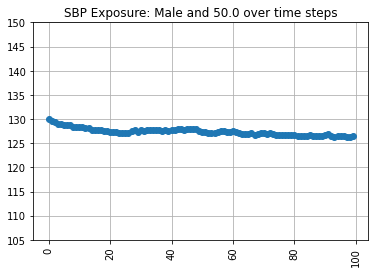

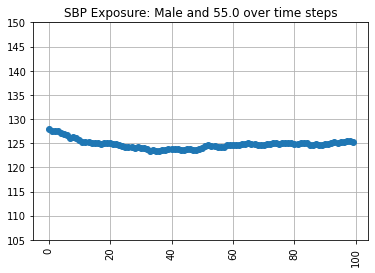

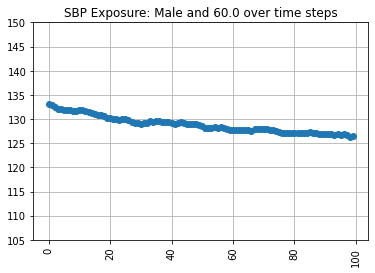

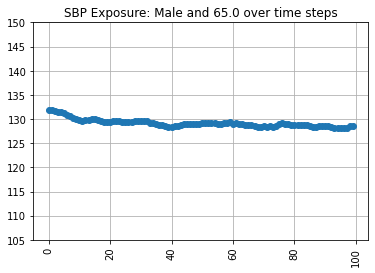

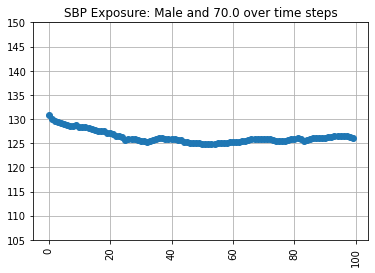

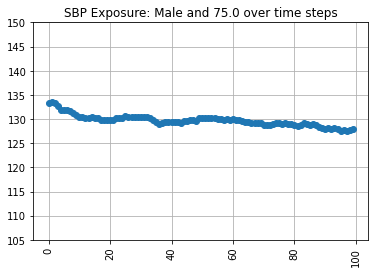

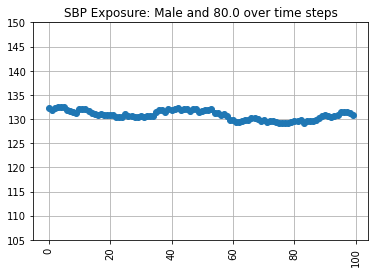

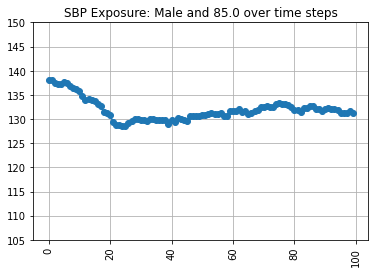

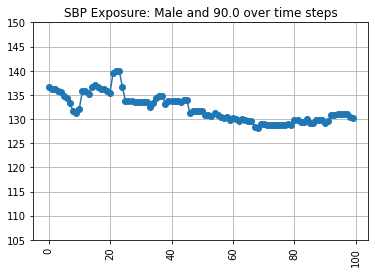

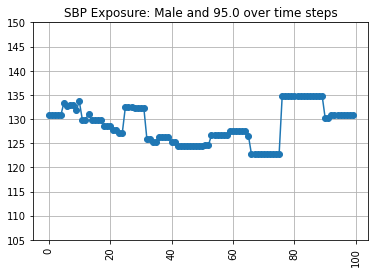

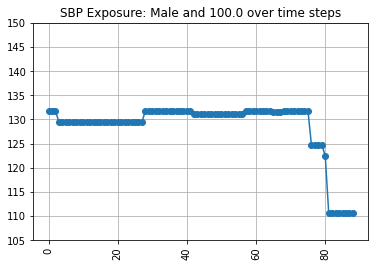

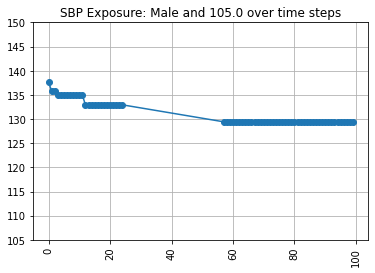

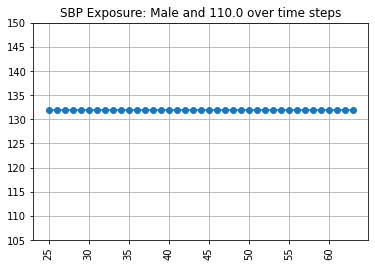

In [51]:
for sex in sbp_exp_step.sex.unique():
    for age in sbp_exp_step.age_start.unique():
        plt.figure() 
        subdata = sbp_exp_step.loc[(sbp_exp_step.sex==sex) & (sbp_exp_step.age_start == age)]
        plt.plot(subdata['step'], subdata['mean'], marker='o')
        plt.title(f'SBP Exposure: {sex} and {age} over time steps') 
        plt.xticks(rotation=90) 
        plt.ylim(105, 150)
        plt.grid()

In [52]:
ldl_exp_step = (data_all
                .groupby(['age_start', 'sex', 'step'])
                .high_ldl.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
ldl_exp_step.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,2.614019,1.060160,4.488018
1,25.0,Female,1,2.607706,1.029476,4.489927
2,25.0,Female,2,2.599956,1.010938,4.484201
3,25.0,Female,3,2.596361,0.996157,4.479430
4,25.0,Female,4,2.587963,0.996154,4.481338


In [54]:
%%capture
for sex in ldl_exp_step.sex.unique():
    for age in ldl_exp_step.age_start.unique():
        plt.figure() 
        subdata = ldl_exp_step.loc[(ldl_exp_step.sex==sex) & (ldl_exp_step.age_start == age)]
        plt.plot(subdata['step'], subdata['mean'], marker='o')
        plt.title(f'LDL Exposure: {sex} and {age} over time steps') 
        plt.xticks(rotation=90) 
        plt.ylim(2, 3.5)
        plt.grid()

## Standard Deviation Testing
### For LDL-C First

#### Load in the Artifact

In [55]:
ldl_exp_std = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure_standard_deviation')
ldl_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_exp_std.age_start,ldl_exp_std.age_end)]
ldl_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,0.866901,0.810395,0.924996,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,0.834644,0.785313,0.885991,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,0.854927,0.808928,0.901343,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,0.874483,0.826285,0.922943,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,0.900536,0.855616,0.945259,Alabama,exposure_standard_deviation,45_to_49


In [56]:
ldl_std = (data1
                .groupby(['age_start', 'sex'])
                .high_ldl.describe()
                .filter(['std'])
                .reset_index())
ldl_std.head()

,age_start,sex,std
0,25.0,Female,0.895407
1,25.0,Male,0.905610
2,30.0,Female,0.884444
3,30.0,Male,0.890126
4,35.0,Female,0.846148


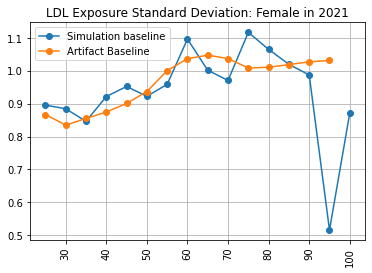

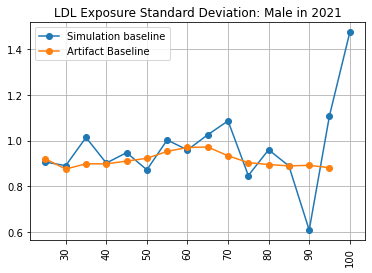

In [57]:
for sex in ldl_std.sex.unique():
    plt.figure() 
    subdata = ldl_std.loc[(ldl_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = ldl_exp_std.loc[(ldl_exp_std.sex==sex) & (ldl_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'LDL Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

The standard deviation looks pretty good here! 

### Now for SBP

In [58]:
sbp_exp_std = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure_standard_deviation')
sbp_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_exp_std.age_start,sbp_exp_std.age_end)]
sbp_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,10.454106,10.024166,10.880320,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,11.315841,10.866911,11.757483,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,13.122234,12.687791,13.516641,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,14.592419,14.094234,15.091773,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,15.887863,15.414401,16.355687,Alabama,exposure_standard_deviation,45_to_49


In [59]:
sbp_std = (data1
                .groupby(['age_start', 'sex'])
                .high_sbp.describe()
                .filter(['std'])
                .reset_index())
sbp_std.head()

,age_start,sex,std
0,25.0,Female,10.088955
1,25.0,Male,10.188180
2,30.0,Female,11.704081
3,30.0,Male,12.319051
4,35.0,Female,14.304625


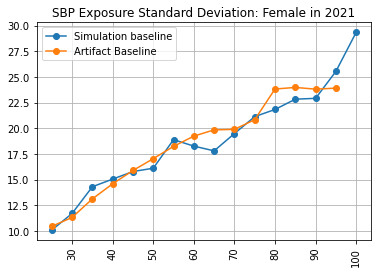

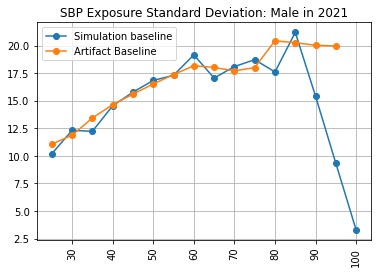

In [60]:
for sex in sbp_std.sex.unique():
    plt.figure() 
    subdata = sbp_std.loc[(sbp_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = sbp_exp_std.loc[(sbp_exp_std.sex==sex) & (sbp_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    #plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

A little funky at the start but I would guess this is due to very small numbers at the youngest age groups. Overall this looks fine.

### Lastly, BMI

In [61]:
bmi_exp_std = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure_standard_deviation')
bmi_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_exp_std.age_start,bmi_exp_std.age_end)]
bmi_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,9.300590,8.907572,9.720854,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,9.256498,8.906606,9.615011,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,9.200298,8.854663,9.558446,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,9.153566,8.816779,9.497864,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,8.979148,8.682577,9.302267,Alabama,exposure_standard_deviation,45_to_49


In [62]:
bmi_std = (data1
                .groupby(['age_start', 'sex'])
                .high_bmi.describe()
                .filter(['std'])
                .reset_index())
bmi_std.head()

#Is the orange a mean and the blue a draw? Need to check 

,age_start,sex,std
0,25.0,Female,7.295979
1,25.0,Male,6.259707
2,30.0,Female,6.942931
3,30.0,Male,5.945805
4,35.0,Female,6.505583


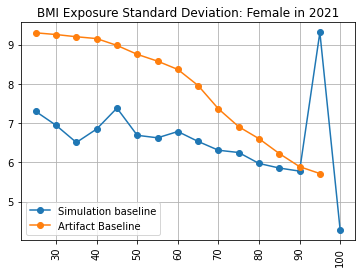

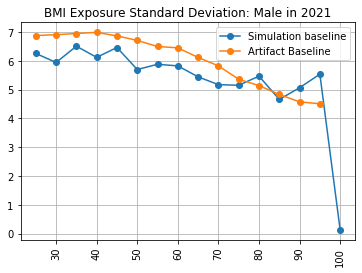

In [63]:
for sex in bmi_std.sex.unique():
    plt.figure() 
    subdata = bmi_std.loc[(bmi_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = bmi_exp_std.loc[(bmi_exp_std.sex==sex) & (bmi_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.title(f'BMI Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Draw 0', 'Draw 1']) 

### FPG Standard Deviation

In [64]:
fpg_exp_std = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure_standard_deviation')
fpg_exp_std['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_exp_std.age_start,fpg_exp_std.age_end)]
fpg_exp_std.head()

/tmp/ipykernel_3409029/184003082.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,1.192216,0.823940,1.595092,Alabama,exposure_standard_deviation,25_to_29
1,Female,30.0,35.0,2019,2020,1.344822,1.027009,1.703150,Alabama,exposure_standard_deviation,30_to_34
2,Female,35.0,40.0,2019,2020,1.701607,1.352960,2.083557,Alabama,exposure_standard_deviation,35_to_39
3,Female,40.0,45.0,2019,2020,1.985273,1.600582,2.317516,Alabama,exposure_standard_deviation,40_to_44
4,Female,45.0,50.0,2019,2020,1.969448,1.582183,2.352557,Alabama,exposure_standard_deviation,45_to_49


In [65]:
fpg_std = (data1
                .groupby(['age_start', 'sex'])
                .high_fpg.describe()
                .filter(['std'])
                .reset_index())
fpg_std.head()

,age_start,sex,std
0,25.0,Female,1.346607
1,25.0,Male,0.582338
2,30.0,Female,1.038948
3,30.0,Male,1.546426
4,35.0,Female,1.799750


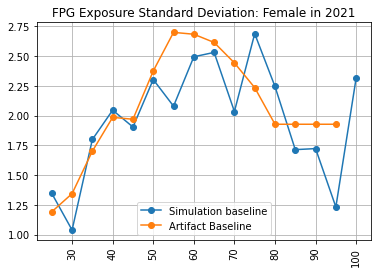

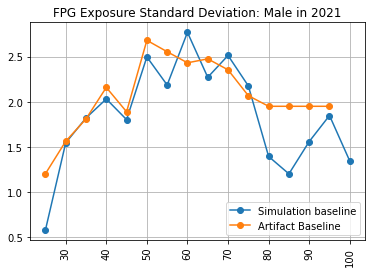

In [66]:
for sex in fpg_std.sex.unique():
    plt.figure() 
    subdata = fpg_std.loc[(fpg_std.sex==sex)]
    plt.plot(subdata['age_start'], subdata['std'], marker='o')
    subdata2 = fpg_exp_std.loc[(fpg_exp_std.sex==sex) & (fpg_exp_std.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o')
    plt.title(f'FPG Exposure Standard Deviation: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Artifact Baseline', 'Artifact 95%']) 

## Relative Risk and PAF Testing 
### Using the regression approach here since we don't have GBD values for RR and PAFs for HF 

Unfortunately that means we have to test single combos of causes and risks. I plan to focus on HF causes which are: HF with IHD and HF residual. Only SBP and BMI have an effect on HF. 

In [23]:
HF_regression = data1[['age_start','sex','high_sbp','high_bmi','high_ldl','hf_ihd','hf_resid','acute_mi']]
HF_regression['bmi_exposure'] = np.where(HF_regression.high_bmi < 22.5, 0, (HF_regression.high_bmi - 22.5))
HF_regression['sbp_exposure'] = np.where(HF_regression.high_sbp < 120, 0, (HF_regression.high_sbp - 120)/10)
HF_regression['hf_sum'] = HF_regression.hf_ihd + HF_regression.hf_resid
HF_regression.head()

,age_start,sex,high_sbp,high_bmi,high_ldl,hf_ihd,hf_resid,acute_mi,bmi_exposure,sbp_exposure,hf_sum
0,45.0,Female,127.134134,24.802611,2.644998,0.000024,0.000063,0.000012,2.302611,0.713413,0.000087
1,40.0,Male,131.808766,27.165902,3.376564,0.000020,0.000056,0.000022,4.665902,1.180877,0.000075
2,50.0,Female,106.466069,33.998750,2.074324,0.000052,0.000096,0.000031,11.498750,0.000000,0.000149
3,30.0,Male,109.868926,27.233734,3.756715,0.000012,0.000055,0.000005,4.733734,0.000000,0.000067
6,30.0,Male,132.593806,24.365348,1.946794,0.000017,0.000075,0.000003,1.865348,1.259381,0.000092


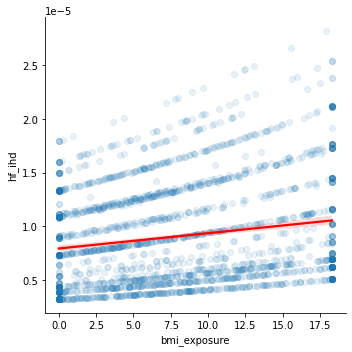

In [47]:
HF_regression_small = HF_regression.loc[(HF_regression.age_start < 40)]
sns.lmplot(x='bmi_exposure',y='hf_ihd',data=HF_regression_small, line_kws={'color': 'red'},scatter_kws={'alpha':0.1})

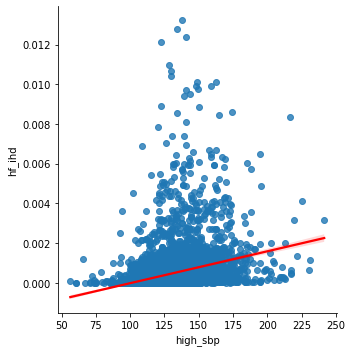

In [25]:
sns.lmplot(x='high_sbp',y='hf_ihd',data=HF_regression, line_kws={'color': 'red'})

In [ ]:
model = smf.logit("hf_ihd ~ bmi_exposure", data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='bmi_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df.head()

In [71]:
rel_risk = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk')
bmi_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
bmi_rr_hf = bmi_rr.loc[(bmi_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease')| (bmi_rr['affected_entity']=='heart_failure_residual')]
bmi_rr_hf.head()

,affected_entity,mean
3,heart_failure_from_ischemic_heart_disease,1.134219
4,heart_failure_residual,1.134219


In [ ]:
model = smf.logit('hf_resid ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_ihd ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
model = smf.logit('hf_sum ~ sbp_exposure', data = HF_regression).fit()
coeff = model.params
results_df = pd.DataFrame({"coeff":coeff})
results_df = results_df.loc[results_df.index=='sbp_exposure']
results_df['rr'] = np.exp(results_df.coeff)
results_df

In [ ]:
rel_risk = art.load('risk_factor.categorical_high_systolic_blood_pressure.relative_risk')
sbp_rr = (rel_risk
                .groupby(['affected_entity'])
                .draw_0.describe()
                .filter(['mean'])
                .reset_index())
sbp_rr_hf = sbp_rr.loc[(sbp_rr['affected_entity']=='heart_failure_from_ischemic_heart_disease') | (sbp_rr['affected_entity']=='heart_failure_residual')]
sbp_rr_hf.head()

## Checking on the GBD HF Incidence Data

In [ ]:
gbd_hf_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 6,
         metric_id = 3,
         source='epi')

In [ ]:
gbd_hf_inc

In [ ]:
plt.hist(gbd_hf_inc.draw_0, bins=25)

In [ ]:
def load_artifact_key(word:str, cause:str, measure:str):
    data = pd.DataFrame()
    for i in ['alabama']:
        
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25', 'draw==0']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
    return data

In [ ]:
data_MI = data1[['age_start','sex','high_ldl','high_sbp','high_bmi','high_fpg','acute_myocardial_infarction_event_count']]
data_MI['acute_MI_binary'] = np.where(data_MI['acute_myocardial_infarction_event_count'] == 0, 0, 1)
data_MI.head()

In [ ]:
art_MI_inc = load_artifact_key('cause', 'myocardial_infarction', 'incidence_rate')
art_MI_inc = art_MI_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_MI_inc.head()

'risk_factor.high_ldl_cholesterol.relative_risk'

'risk_factor.high_ldl_cholesterol.population_attributable_fraction'

In [ ]:
art_MI_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_MI_rr_ldl = art_MI_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_MI_rr_ldl = art_MI_rr_ldl.loc[art_MI_rr_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_ldl.head()

In [ ]:
art_MI_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_MI_rr_sbp = art_MI_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_MI_rr_sbp = art_MI_rr_sbp.loc[art_MI_rr_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_sbp.head()

In [ ]:
art_MI_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_MI_rr_bmi = art_MI_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_MI_rr_bmi = art_MI_rr_bmi.loc[art_MI_rr_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_bmi.head()

In [ ]:
art_MI_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_MI_rr_fpg = art_MI_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_MI_rr_fpg = art_MI_rr_fpg.loc[art_MI_rr_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_rr_fpg.head()

In [ ]:
art_MI_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_MI_paf_ldl = art_MI_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_MI_paf_ldl = art_MI_paf_ldl.loc[art_MI_paf_ldl['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_ldl.head()

In [ ]:
art_MI_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_MI_paf_sbp = art_MI_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_MI_paf_sbp = art_MI_paf_sbp.loc[art_MI_paf_sbp['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_sbp.head()

In [ ]:
art_MI_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_MI_paf_bmi = art_MI_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_MI_paf_bmi = art_MI_paf_bmi.loc[art_MI_paf_bmi['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_bmi.head()

In [ ]:
art_MI_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_MI_paf_fpg = art_MI_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_MI_paf_fpg = art_MI_paf_fpg.loc[art_MI_paf_fpg['affected_entity'] == 'acute_myocardial_infarction']
art_MI_paf_fpg.head()

In [ ]:
from get_draws.api import get_draws
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==493]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==493]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==493]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==493]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_MI.merge(art_MI_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_MI_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_MI_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_MI_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_MI_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_MI_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_MI_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_MI_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_MI_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
data_merged.loc[data_merged['inc_i_fpg']>1]

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
#data_merged = data_merged.loc[data_merged['high_bmi']<70]
#data_merged = data_merged.loc[data_merged['high_fpg']<20]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
p.head()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

There are some interesting things here for FPG - seems like a cluster of very high values in 80+ year olds which are leading to strange answers. Need to look into the exposure values further. Also the median is being odd? 

## Same approach for stroke

In [ ]:
data_stroke = data1[['age_start','sex','high_ldl_cholesterol','high_sbp','high_bmi','high_fpg','acute_ischemic_stroke_event_count']]
data_stroke = data_stroke.loc[data_stroke['age_start'] > 20]
data_stroke.head()

In [ ]:
art_stroke_inc = load_artifact_key('cause', 'ischemic_stroke', 'incidence_rate')
art_stroke_inc = art_stroke_inc.rename(columns={"draw_0": "inc"}).reset_index()
art_stroke_inc.head()

In [ ]:
art_stroke_rr_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'relative_risk')
art_stroke_rr_ldl = art_stroke_rr_ldl.rename(columns={"draw_0": "rr_ldl"}).reset_index()
art_stroke_rr_ldl = art_stroke_rr_ldl.loc[art_stroke_rr_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_ldl.head()

In [ ]:
art_stroke_rr_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'relative_risk')
art_stroke_rr_sbp = art_stroke_rr_sbp.rename(columns={"draw_0": "rr_sbp"}).reset_index()
art_stroke_rr_sbp = art_stroke_rr_sbp.loc[art_stroke_rr_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_sbp.head()

In [ ]:
art_stroke_rr_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'relative_risk')
art_stroke_rr_bmi = art_stroke_rr_bmi.rename(columns={"draw_0": "rr_bmi"}).reset_index()
art_stroke_rr_bmi = art_stroke_rr_bmi.loc[art_stroke_rr_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_bmi.head()

In [ ]:
art_stroke_rr_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'relative_risk')
art_stroke_rr_fpg = art_stroke_rr_fpg.rename(columns={"draw_0": "rr_fpg"}).reset_index()
art_stroke_rr_fpg = art_stroke_rr_fpg.loc[art_stroke_rr_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_rr_fpg.head()

In [ ]:
art_stroke_paf_ldl = load_artifact_key('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
art_stroke_paf_ldl = art_stroke_paf_ldl.rename(columns={"draw_0": "paf_ldl"}).reset_index()
art_stroke_paf_ldl = art_stroke_paf_ldl.loc[art_stroke_paf_ldl['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_ldl.head()

In [ ]:
art_stroke_paf_sbp = load_artifact_key('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
art_stroke_paf_sbp = art_stroke_paf_sbp.rename(columns={"draw_0": "paf_sbp"}).reset_index()
art_stroke_paf_sbp = art_stroke_paf_sbp.loc[art_stroke_paf_sbp['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_sbp.head()

In [ ]:
art_stroke_paf_bmi = load_artifact_key('risk_factor', 'high_body_mass_index_in_adults', 'population_attributable_fraction')
art_stroke_paf_bmi = art_stroke_paf_bmi.rename(columns={"draw_0": "paf_bmi"}).reset_index()
art_stroke_paf_bmi = art_stroke_paf_bmi.loc[art_stroke_paf_bmi['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_bmi.head()

In [ ]:
art_stroke_paf_fpg = load_artifact_key('risk_factor', 'high_fasting_plasma_glucose', 'population_attributable_fraction')
art_stroke_paf_fpg = art_stroke_paf_fpg.rename(columns={"draw_0": "paf_fpg"}).reset_index()
art_stroke_paf_fpg = art_stroke_paf_fpg.loc[art_stroke_paf_fpg['affected_entity'] == 'acute_ischemic_stroke']
art_stroke_paf_fpg.head()

In [ ]:
rrs_sbp = get_draws(gbd_id_type='rei_id',
               gbd_id=107,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_sbp = rrs_sbp.loc[rrs_sbp.cause_id==495]
rrs_sbp = rrs_sbp[['age_group_id','sex_id','draw_0']]
rrs_sbp['age_start'] = np.where(rrs_sbp['age_group_id']==10,25,np.where(rrs_sbp['age_group_id']==11,30,np.where(rrs_sbp['age_group_id']==12,35,np.where(rrs_sbp['age_group_id']==13,40,np.where(rrs_sbp['age_group_id']==14,45,np.where(rrs_sbp['age_group_id']==15,50,np.where(rrs_sbp['age_group_id']==16,55,np.where(rrs_sbp['age_group_id']==17,60,np.where(rrs_sbp['age_group_id']==18,65,np.where(rrs_sbp['age_group_id']==19,70,np.where(rrs_sbp['age_group_id']==20,75,np.where(rrs_sbp['age_group_id']==30,80,np.where(rrs_sbp['age_group_id']==31,85,np.where(rrs_sbp['age_group_id']==32,90,0))))))))))))))
rrs_sbp['sex'] = np.where(rrs_sbp['sex_id']==1,'Male','Female')
rrs_sbp = rrs_sbp.rename(columns={"draw_0": "rr_gbd_sbp"}).reset_index()
rrs_sbp.head()

In [ ]:
rrs = get_draws(gbd_id_type='rei_id',
               gbd_id=367,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs = rrs.loc[rrs.cause_id==495]
rrs = rrs[['age_group_id','sex_id','draw_0']]
rrs['age_start'] = np.where(rrs['age_group_id']==10,25,np.where(rrs['age_group_id']==11,30,np.where(rrs['age_group_id']==12,35,np.where(rrs['age_group_id']==13,40,np.where(rrs['age_group_id']==14,45,np.where(rrs['age_group_id']==15,50,np.where(rrs['age_group_id']==16,55,np.where(rrs['age_group_id']==17,60,np.where(rrs['age_group_id']==18,65,np.where(rrs['age_group_id']==19,70,np.where(rrs['age_group_id']==20,75,np.where(rrs['age_group_id']==30,80,np.where(rrs['age_group_id']==31,85,np.where(rrs['age_group_id']==32,90,0))))))))))))))
rrs['sex'] = np.where(rrs['sex_id']==1,'Male','Female')
rrs = rrs.rename(columns={"draw_0": "rr_gbd_ldl"}).reset_index()
rrs.head()

In [ ]:
rrs_bmi = get_draws(gbd_id_type='rei_id',
               gbd_id=370,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_bmi = rrs_bmi.loc[rrs_bmi.cause_id==495]
rrs_bmi = rrs_bmi[['age_group_id','sex_id','draw_0']]
rrs_bmi['age_start'] = np.where(rrs_bmi['age_group_id']==10,25,np.where(rrs_bmi['age_group_id']==11,30,np.where(rrs_bmi['age_group_id']==12,35,np.where(rrs_bmi['age_group_id']==13,40,np.where(rrs_bmi['age_group_id']==14,45,np.where(rrs_bmi['age_group_id']==15,50,np.where(rrs_bmi['age_group_id']==16,55,np.where(rrs_bmi['age_group_id']==17,60,np.where(rrs_bmi['age_group_id']==18,65,np.where(rrs_bmi['age_group_id']==19,70,np.where(rrs_bmi['age_group_id']==20,75,np.where(rrs_bmi['age_group_id']==30,80,np.where(rrs_bmi['age_group_id']==31,85,np.where(rrs_bmi['age_group_id']==32,90,0))))))))))))))
rrs_bmi['sex'] = np.where(rrs_bmi['sex_id']==1,'Male','Female')
rrs_bmi = rrs_bmi.rename(columns={"draw_0": "rr_gbd_bmi"}).reset_index()
rrs_bmi.head()

In [ ]:
rrs_fpg = get_draws(gbd_id_type='rei_id',
               gbd_id=105,
               gbd_round_id=6,
               year_id=2019,
               age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33],
               sex_id=[1,2],
               source='rr',
               decomp_step='step4',
               status='best'
               )
rrs_fpg = rrs_fpg.loc[rrs_fpg.cause_id==495]
rrs_fpg = rrs_fpg[['age_group_id','sex_id','draw_0']]
rrs_fpg['age_start'] = np.where(rrs_fpg['age_group_id']==10,25,np.where(rrs_fpg['age_group_id']==11,30,np.where(rrs_fpg['age_group_id']==12,35,np.where(rrs_fpg['age_group_id']==13,40,np.where(rrs_fpg['age_group_id']==14,45,np.where(rrs_fpg['age_group_id']==15,50,np.where(rrs_fpg['age_group_id']==16,55,np.where(rrs_fpg['age_group_id']==17,60,np.where(rrs_fpg['age_group_id']==18,65,np.where(rrs_fpg['age_group_id']==19,70,np.where(rrs_fpg['age_group_id']==20,75,np.where(rrs_fpg['age_group_id']==30,80,np.where(rrs_fpg['age_group_id']==31,85,np.where(rrs_fpg['age_group_id']==32,90,0))))))))))))))
rrs_fpg['sex'] = np.where(rrs_fpg['sex_id']==1,'Male','Female')
rrs_fpg = rrs_fpg.rename(columns={"draw_0": "rr_gbd_fpg"}).reset_index()
rrs_fpg.head()

In [ ]:
tmrel_ldl = 1
tmrel_sbp = 112.5
tmrel_bmi = 22.5
tmrel_fpg = 5.1

data_merged = (data_stroke.merge(art_stroke_inc[['age_start','sex','inc']], on=['age_start','sex'])
               .merge(art_stroke_paf_ldl[['age_start','sex','paf_ldl']], on=['age_start','sex'])
               .merge(art_stroke_paf_sbp[['age_start','sex','paf_sbp']], on=['age_start','sex'])
               .merge(art_stroke_paf_bmi[['age_start','sex','paf_bmi']], on=['age_start','sex'])
               .merge(art_stroke_paf_fpg[['age_start','sex','paf_fpg']], on=['age_start','sex'])
              .merge(art_stroke_rr_ldl[['age_start','sex','rr_ldl']], on=['age_start','sex'])
              .merge(art_stroke_rr_sbp[['age_start','sex','rr_sbp']], on=['age_start','sex'])
              .merge(art_stroke_rr_bmi[['age_start','sex','rr_bmi']], on=['age_start','sex'])
              .merge(art_stroke_rr_fpg[['age_start','sex','rr_fpg']], on=['age_start','sex'])
              .merge(rrs[['age_start','sex','rr_gbd_ldl']], on=['age_start','sex'])
              .merge(rrs_bmi[['age_start','sex','rr_gbd_bmi']], on=['age_start','sex'])
              .merge(rrs_fpg[['age_start','sex','rr_gbd_fpg']], on=['age_start','sex'])
              .merge(rrs_sbp[['age_start','sex','rr_gbd_sbp']], on=['age_start','sex']))
data_merged['exposure_i_ldl'] = np.where(data_merged.high_ldl_cholesterol < 1, 0, (data_merged.high_ldl_cholesterol - tmrel_ldl))
data_merged['exposure_i_sbp'] = np.where(data_merged.high_sbp < 112.5, 0, (data_merged.high_sbp - tmrel_sbp)/10)
data_merged['exposure_i_bmi'] = np.where(data_merged.high_bmi < tmrel_bmi, 0, (data_merged.high_bmi - tmrel_bmi)/5)
data_merged['exposure_i_fpg'] = np.where(data_merged.high_fpg < tmrel_fpg, 0, (data_merged.high_fpg - tmrel_fpg))
data_merged['rr_i_ldl'] = np.exp(np.log(data_merged.rr_gbd_ldl) * data_merged.exposure_i_ldl)
data_merged['rr_i_sbp'] = np.exp(np.log(data_merged.rr_gbd_sbp) * data_merged.exposure_i_sbp)
data_merged['rr_i_bmi'] = np.exp(np.log(data_merged.rr_gbd_bmi) * data_merged.exposure_i_bmi)
data_merged['rr_i_fpg'] = np.exp(np.log(data_merged.rr_gbd_fpg) * data_merged.exposure_i_fpg)
data_merged['inc_i_ldl'] = data_merged.inc * (1 - data_merged.paf_ldl) * data_merged.rr_i_ldl
data_merged['inc_i_sbp'] = data_merged.inc * (1 - data_merged.paf_sbp) * data_merged.rr_i_sbp
data_merged['inc_i_bmi'] = data_merged.inc * (1 - data_merged.paf_bmi) * data_merged.rr_i_bmi
data_merged['inc_i_fpg'] = data_merged.inc * (1 - data_merged.paf_fpg) * data_merged.rr_i_fpg
data_merged.head()

In [ ]:
#data_merged = data_merged.loc[data_merged['inc_i_sbp']<1]
p = data_merged.groupby(['sex','age_start','inc']).mean()[['inc_i_ldl','inc_i_sbp','inc_i_bmi','inc_i_fpg']].reset_index()

In [ ]:
for sex in p.sex.unique():
    plt.figure(dpi=120)
    subdata = p.loc[p.sex == sex]
    plt.plot(subdata.age_start, subdata.inc, marker='o', label='Artifact')
    plt.plot(subdata.age_start, subdata.inc_i_ldl, marker='o', label='Simulated population mean_ldl')
    plt.plot(subdata.age_start, subdata.inc_i_sbp, marker='o', label='Simulated population mean_sbp')
    plt.plot(subdata.age_start, subdata.inc_i_bmi, marker='o', label='Simulated population mean_bmi')
    plt.plot(subdata.age_start, subdata.inc_i_fpg, marker='o', label='Simulated population mean_fpg')
    plt.legend()
    plt.title(f'Artifact Comparison for: {sex}') 
    plt.grid()

Less here, this matches with what we saw in the other notebook - MI is more worrisome 